This notebook will be mainly used for the IBM Applied Data Science Specialisation Capstone Project

In [79]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [80]:
print ("Hello Capstone Project Course!")

Hello Capstone Project Course!


<h1 align=center><font size = 5>Part I - Segmenting and Clustering Neighborhoods in Toronto</font></h1>

#### Retreiving the URL of Wikipedia page that contains Toronto neighborhood data and creating a Beautiful soup object in order to scrape the Wikipedia page and wrangle the data.

In [81]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

#print(soup.prettify()) #Investigate the Beuatiful soup object

#### Wrangling and cleaning of Toronto neighborhood data in order to be read as a pandas data frame.
1) Postal code contains up to 3 characters and so is extracted using tablerow.p.text

2) Borough data is extracted by spliting the cell by '(' which is the begining of a Neigbourhood and so the first part [0] would be the Borough.

3) Neigbourhood data is the 2nd part but as more than one neighborhood can exist in one postal code area e.g. Harbourfront and Regent Park in M5A. These are combined into one row with the neighborhoods separated with a comma rather than a '/'.

In [82]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

#print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
table.findAll('td')[100].p.text[:3] #testing how to extract the data

'M2P'

In [6]:
(table.findAll('td')[100].span.text).split('(')

['North York', 'York Mills West)']

In [7]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


##### Number of rows in dataframe.

In [8]:
df.shape

(103, 3)

## Part I, Step 2

#### Obtaining the latitude and the longitude coordinates of each neighborhood. 

In [9]:
import geocoder # import geocoder

In [10]:
# initialize your variable to None
lat_lng_coords = None

# loop until you get the coordinates
while(lat_lng_coords is None):
    g = geocoder.google('{}, Toronto, Ontario'.format('M3A'))
    lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

KeyboardInterrupt: 

In [11]:
#test for a more common example
while(lat_lng_coords is None):
    g = geocoder.google('Mountain View, CA')
    lat_lng_coords = g.latlng


KeyboardInterrupt: 

## Geocoder did not work otherwise would have added latitude and longitude data as below.

In [12]:
a=np.empty(df.shape[0])
a[:]=np.nan
latitude=a.tolist()
longitude=a.tolist()

In [13]:
df['Latitude']=latitude
df['Longitude']=longitude

In [14]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,NaN,NaN
1,M4A,North York,Victoria Village,NaN,NaN
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",NaN,NaN
3,M6A,North York,"Lawrence Manor, Lawrence Heights",NaN,NaN
4,M7A,Queen's Park,Ontario Provincial Government,NaN,NaN


In [15]:
df['PostalCode'][0]

'M3A'

In [16]:
for row in range(df.shape[0]):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(df['PostalCode'][row]))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    df['Latitude'][row]=latitude
    df['Longitude'][row]=longitude
    

KeyboardInterrupt: 

## Instead will use csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

In [83]:
geo=pd.read_csv('Geospatial_Coordinates.csv')

In [84]:
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [85]:
geo.shape

(103, 3)

In [87]:
df = df.join(geo.set_index('Postal Code'), on='PostalCode', how='inner')
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [24]:
df.describe(include='all')

,PostalCode,Borough,Neighborhood,Latitude,Longitude
count,103,103,103,103.000000,103.000000
unique,103,15,103,NaN,NaN
top,M9M,North York,Christie,NaN,NaN
freq,1,24,1,NaN,NaN
mean,NaN,NaN,NaN,43.704608,-79.397153
std,NaN,NaN,NaN,0.052463,0.097146
min,NaN,NaN,NaN,43.602414,-79.615819
25%,NaN,NaN,NaN,43.660567,-79.464763
50%,NaN,NaN,NaN,43.696948,-79.388790
75%,NaN,NaN,NaN,43.745320,-79.340923


In [22]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>

#### Using geopy library to get the latitude and longitude values of Toronto

In [25]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Creating a map of Toronto with neighborhoods superimposed on top.

In [77]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

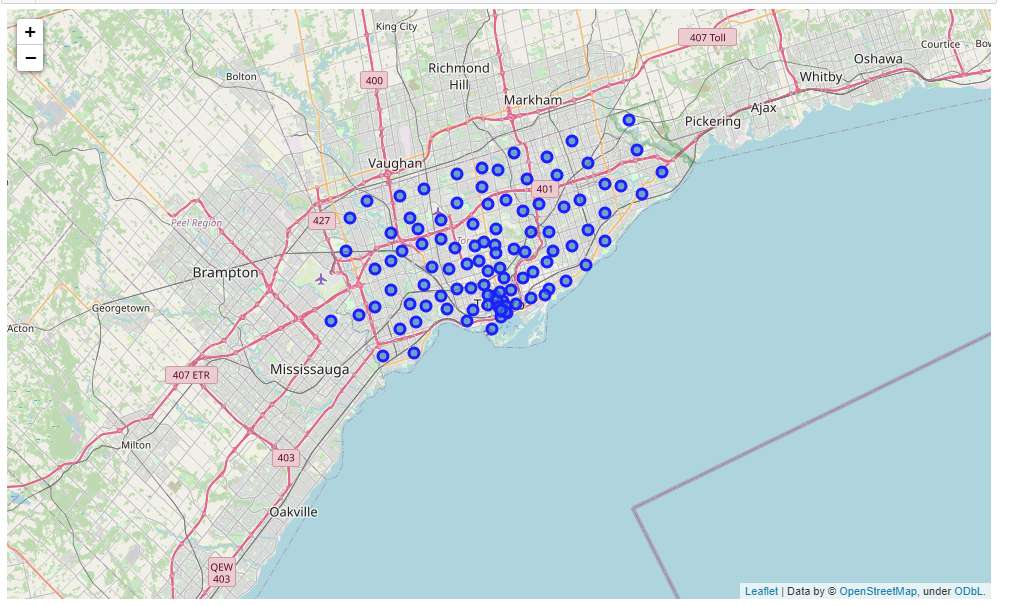

#### Extracting and creating a map of Toronto neighborhoods with 'Toronto' in the Borough name.

In [38]:
toronto_b=df[df['Borough'].str.contains('Toronto')]
toronto_b.reset_index(drop=True,inplace=True)
print(toronto_b.shape)
toronto_b.head(5)

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [36]:
toronto_b.describe(include='all')

,PostalCode,Borough,Neighborhood,Latitude,Longitude
count,39,39,39,39.000000,39.000000
unique,39,7,39,NaN,NaN
top,M4T,Downtown Toronto,Christie,NaN,NaN
freq,1,17,1,NaN,NaN
mean,NaN,NaN,NaN,43.667726,-79.388556
std,NaN,NaN,NaN,0.023643,0.038358
min,NaN,NaN,NaN,43.628947,-79.484450
25%,NaN,NaN,NaN,43.649765,-79.405678
50%,NaN,NaN,NaN,43.662696,-79.384568
75%,NaN,NaN,NaN,43.679560,-79.375132


In [45]:
toronto_b['Latitude'].mean()

43.6677258974359

In [76]:
# create map using mean latitude and longitude values of toronto_b
map_toronto = folium.Map(location=[toronto_b['Latitude'].mean(), toronto_b['Longitude'].mean()], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_b['Latitude'], toronto_b['Longitude'], toronto_b['Borough'], toronto_b['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

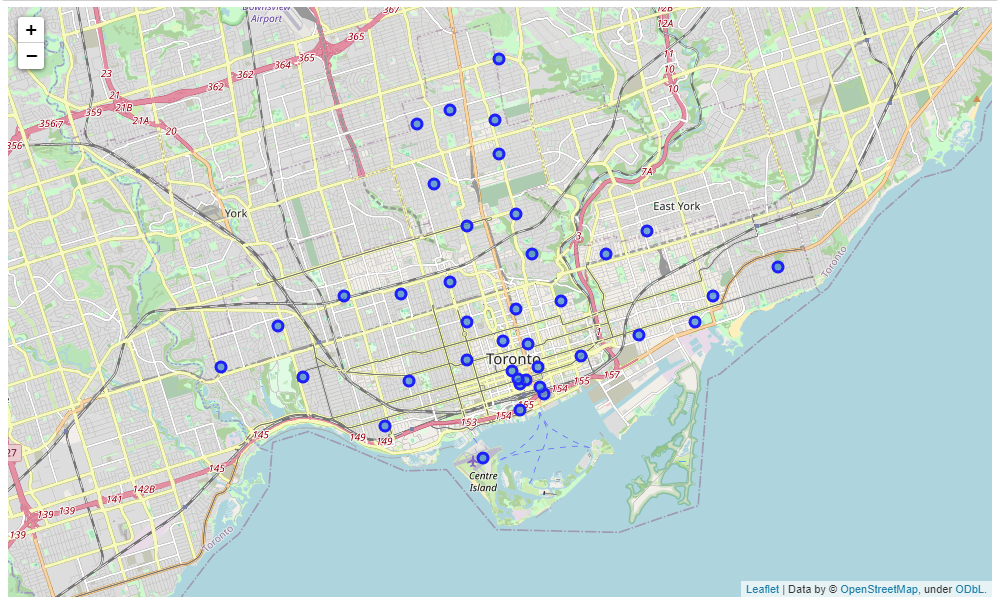

#### Foursquare Credentials and Version

Credentials will be removed for github upload

In [73]:
CLIENT_ID = '####' # your Foursquare ID
CLIENT_SECRET = '####' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ####
CLIENT_SECRET:####


#### Function to get nearby venues to a lat,long location via foursquare (limited to 100 venues per location)

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Running above function on each neighborhood and create a new dataframe called toronto_venues.

In [53]:
toronto_venues = getNearbyVenues(names=toronto_b['Neighborhood'],
                                   latitudes=toronto_b['Latitude'],
                                   longitudes=toronto_b['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [54]:
print(toronto_venues.shape)
toronto_venues.head()

(1590, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Number of venues returned for each neighborhood

In [55]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",25,25,25,25,25,25
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,73,73,73,73,73,73
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,37,37,37,37,37,37
Davisville North,8,8,8,8,8,8


#### unique categories from the returned venues

In [56]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


## Clustering Neighborhoods

In [57]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

Running _k_-means to cluster neighborhoods into 5 clusters.

In [58]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


Function that returns top 10 venues for neighborhood.

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Seafood Restaurant,Restaurant,Beer Bar,Pharmacy,Farmers Market,Cheese Shop,Beach
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Gym / Fitness Center,Gym,Pet Store,Performing Arts Venue,Nightclub,Music Venue,Italian Restaurant
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Boat or Ferry,Harbor / Marina,Rental Car Location,Coffee Shop,Plane,Bar,Sculpture Garden
3,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant,Miscellaneous Shop,Japanese Restaurant
4,Christie,Grocery Store,Café,Park,Nightclub,Restaurant,Candy Store,Athletics & Sports,Italian Restaurant,Baby Store,Coffee Shop


In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [63]:
toronto_merged = toronto_b

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Gym / Fitness Center,Event Space,Restaurant
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Bubble Tea Shop,Café,Middle Eastern Restaurant,Cosmetics Shop,Lingerie Store,Hotel,Burger Joint,Pizza Place
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Cosmetics Shop,Art Gallery,Beer Bar,Seafood Restaurant,Hotel,Creperie,Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Pizza Place,Asian Restaurant,Health Food Store,Trail,Pub,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Bakery,Cocktail Bar,Seafood Restaurant,Restaurant,Beer Bar,Pharmacy,Farmers Market,Cheese Shop,Beach


In [75]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

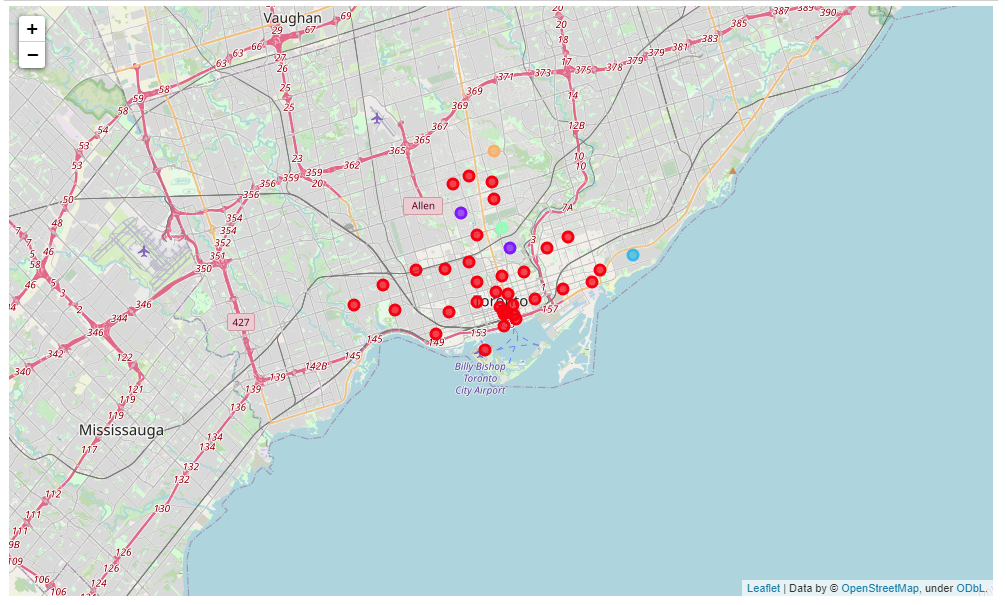

# Breakdown of Clusters

#### Cluster 1 (0)

In [65]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Gym / Fitness Center,Event Space,Restaurant
1,Downtown Toronto,0,Clothing Store,Coffee Shop,Bubble Tea Shop,Café,Middle Eastern Restaurant,Cosmetics Shop,Lingerie Store,Hotel,Burger Joint,Pizza Place
2,Downtown Toronto,0,Coffee Shop,Café,Cocktail Bar,Cosmetics Shop,Art Gallery,Beer Bar,Seafood Restaurant,Hotel,Creperie,Restaurant
4,Downtown Toronto,0,Coffee Shop,Bakery,Cocktail Bar,Seafood Restaurant,Restaurant,Beer Bar,Pharmacy,Farmers Market,Cheese Shop,Beach
5,Downtown Toronto,0,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant,Miscellaneous Shop,Japanese Restaurant
6,Downtown Toronto,0,Grocery Store,Café,Park,Nightclub,Restaurant,Candy Store,Athletics & Sports,Italian Restaurant,Baby Store,Coffee Shop
7,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Clothing Store,Thai Restaurant,Deli / Bodega,Steakhouse,Cosmetics Shop,Salad Place
8,West Toronto,0,Pharmacy,Bakery,Middle Eastern Restaurant,Bank,Bar,Café,Music Venue,Supermarket,Pizza Place,Pet Store
9,East York/East Toronto,0,Convenience Store,Park,Coffee Shop,Metro Station,Wings Joint,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store
10,Downtown Toronto,0,Coffee Shop,Aquarium,Café,Hotel,Scenic Lookout,Sporting Goods Shop,Fried Chicken Joint,Italian Restaurant,Brewery,Restaurant


#### Cluster 2 (1)

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,1,Park,Trail,Jewelry Store,Sushi Restaurant,Wings Joint,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store
33,Downtown Toronto,1,Park,Playground,Trail,Wings Joint,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


#### Cluster 3 (2)

In [67]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,East Toronto,2,Pizza Place,Asian Restaurant,Health Food Store,Trail,Pub,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant


#### Cluster 4 (3)

In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,3,Gym,Tennis Court,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


#### Cluster 5 (4)

In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,4,Park,Lake,Bus Line,Swim School,Wings Joint,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store
